<a href="https://colab.research.google.com/github/Sievv/AMPs-Against--PS/blob/main/PS_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


                         Sequence  Activity
0  EIYPYVIQELRPTLNELGISTPEELGLDKV         0
1        SFKSTNPSATFSLINRNICHEGYV         0
2                 KWKLFKKIGAVLKVL         1
3              KWCRCVCRRGICRCRCRG         1
4                    KVGFFKPPAAKP         0

Class distribution:
 Activity
0    373
1    102
Name: count, dtype: int64


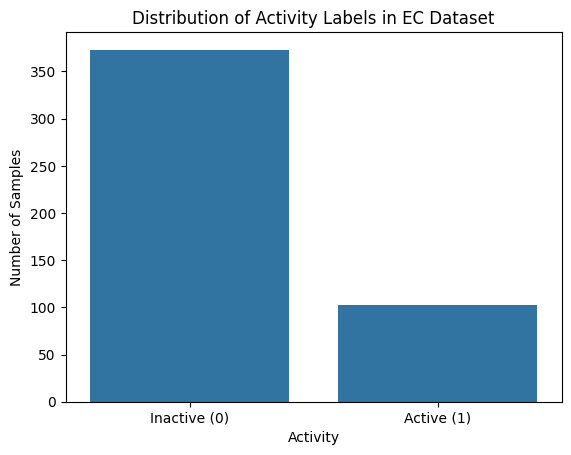

In [2]:
import pandas as pd
# Import necessary libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns


# Load datasets
df_active = pd.read_csv('/content/drive/MyDrive/PS/PS imbalance/Active PS 102.csv')
# Corrected file path for inactive dataset - removed duplicate 'MyDrive'
df_inactive = pd.read_csv('/content/drive/MyDrive/PS/PS imbalance/Inactive 373.csv')

# Strip whitespace from column names
df_active.columns = df_active.columns.str.strip()
df_inactive.columns = df_inactive.columns.str.strip()

# Add activity labels
df_active['Activity'] = 1
df_inactive['Activity'] = 0

# Select only 'Sequence' and 'Activity' columns
df_active = df_active[['Sequence', 'Activity']]
df_inactive = df_inactive[['Sequence', 'Activity']]

# Combine datasets
df_combined = pd.concat([df_active, df_inactive], ignore_index=True)

# Shuffle combined dataset
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Save combined dataset
df_combined.to_csv('/content/drive/MyDrive/PS/PS imbalance/EC_combined.csv', index=False)

# Print first rows and class distribution
print(df_combined.head())
print("\nClass distribution:\n", df_combined['Activity'].value_counts())

# Count number of active and inactive samples
# Corrected df_ec to df_combined to use the combined dataframe
counts = df_combined['Activity'].value_counts().sort_index()

# Create a simple bar plot
sns.barplot(x=counts.index, y=counts.values)

# Add labels and title
plt.xticks([0, 1], ['Inactive (0)', 'Active (1)'])
plt.ylabel('Number of Samples')
plt.title('Distribution of Activity Labels in EC Dataset')

# Show plot
plt.show()

# Show plot
plt.show()

In [3]:
# Split into 80% train and 20% test
from sklearn.model_selection import train_test_split

# Use df_combined instead of df_shuffled for splitting
train_df, test_df = train_test_split(df_combined, test_size=0.2, stratify=df_combined['Activity'], random_state=42)

# Check sizes
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

# Optional: check label distribution
print("Train label distribution:")
print(train_df['Activity'].value_counts(normalize=True))
print("Test label distribution:")
print(test_df['Activity'].value_counts(normalize=True))

Training set size: 380
Test set size: 95
Train label distribution:
Activity
0    0.784211
1    0.215789
Name: proportion, dtype: float64
Test label distribution:
Activity
0    0.789474
1    0.210526
Name: proportion, dtype: float64


In [13]:
# Split into 80% train and 20% test
from sklearn.model_selection import train_test_split

# Split the combined DataFrame into train and test sets with stratification
train_df, test_df = train_test_split(df_combined, test_size=0.2, stratify=df_combined['Activity'], random_state=42)

# Check sizes
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

# Check label distribution in train and test sets
print("Train label distribution:")
print(train_df['Activity'].value_counts(normalize=True))
print("Test label distribution:")
print(test_df['Activity'].value_counts(normalize=True))

# Separate features and target for train and test
X_train = train_df.drop(columns=['Activity'])
y_train = train_df['Activity']
X_test = test_df.drop(columns=['Activity'])
y_test = test_df['Activity']

# Save datasets to CSV for later use
X_train.to_csv('/content/drive/MyDrive/PS/PS imbalance/X_train.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/PS/PS imbalance/y_train.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/PS/PS imbalance/X_test.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/PS/PS imbalance/y_test.csv', index=False)

Training set size: 380
Test set size: 95
Train label distribution:
Activity
0    0.784211
1    0.215789
Name: proportion, dtype: float64
Test label distribution:
Activity
0    0.789474
1    0.210526
Name: proportion, dtype: float64


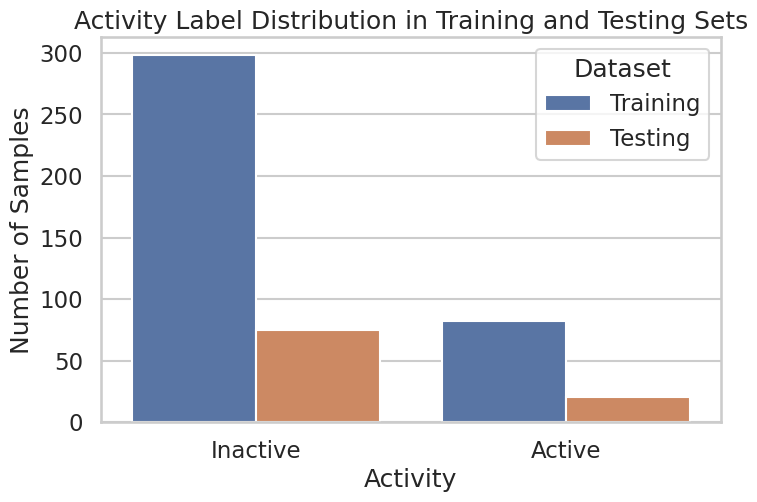

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split


# Count labels in train and test
train_counts = train_df['Activity'].value_counts().sort_index()
test_counts = test_df['Activity'].value_counts().sort_index()


plot_df = pd.DataFrame({
    'Training': train_counts,
    'Testing': test_counts
}).reset_index(names=['Activity_Label'])


plot_df = plot_df.melt(id_vars='Activity_Label', var_name='Dataset', value_name='Count')

# Rename Activity labels for clarity
plot_df['Activity'] = plot_df['Activity_Label'].map({0: 'Inactive', 1: 'Active'})

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='Activity', y='Count', hue='Dataset', data=plot_df)
plt.title('Activity Label Distribution in Training and Testing Sets')
plt.ylabel('Number of Samples')
plt.xlabel('Activity')
plt.show()

In [15]:
!pip install biopython

import pandas as pd
from Bio.SeqUtils import molecular_weight
from Bio.Seq import Seq

# Define peptide feature calculation functions
def calculate_charge(sequence):
    """Calculate net charge: K, R, H (+), D, E (-)"""
    positive = sequence.count('K') + sequence.count('R') + sequence.count('H')
    negative = sequence.count('D') + sequence.count('E')
    return positive - negative

def calculate_molecular_weight(sequence):
    """Calculate molecular weight of peptide sequence"""
    return molecular_weight(Seq(sequence), seq_type='protein')

def calculate_hydrophobicity(sequence):
    """Calculate hydrophobicity based on Kyte-Doolittle scale residues"""
    hydrophobic_residues = 'AVILMFWP'
    hydrophobic_score = sum([1 for aa in sequence if aa in hydrophobic_residues])
    return hydrophobic_score

def calculate_number_of_cysteines(sequence):
    """Count cysteine residues"""
    return sequence.count('C')

def calculate_number_of_disulfide_bridges(sequence):
    """Estimate disulfide bridges as integer division of cysteines by 2"""
    cysteines = sequence.count('C')
    return cysteines // 2

def calculate_isoelectric_point(sequence):
    """Simplified isoelectric point estimate"""
    pKa_acidic = {'D': 3.9, 'E': 4.25}
    pKa_basic = {'K': 10.5, 'R': 12.5, 'H': 6.0}
    acidic_count = sum([sequence.count(aa) for aa in pKa_acidic])
    basic_count = sum([sequence.count(aa) for aa in pKa_basic])
    if acidic_count + basic_count > 0:
        pI = (sum([pKa_acidic[aa] * sequence.count(aa) for aa in pKa_acidic]) +
              sum([pKa_basic[aa] * sequence.count(aa) for aa in pKa_basic])) / (acidic_count + basic_count)
    else:
        pI = 7.0  # Neutral default if no acidic/basic residues
    return pI

def amino_acid_composition(sequence):
    """Calculate percentage composition of each amino acid"""
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    composition = {aa: sequence.count(aa) for aa in amino_acids}
    total_residues = len(sequence)
    composition_percent = {aa: (count / total_residues) * 100 if total_residues > 0 else 0
                          for aa, count in composition.items()}
    return composition_percent

def secondary_structure_features(sequence):
    """Simplified secondary structure feature counts"""
    helix_aa = 'ALIVMFYW'
    sheet_aa = 'FYW'
    turn_aa = 'GP'
    helix = sum([sequence.count(aa) for aa in helix_aa])
    sheet = sum([sequence.count(aa) for aa in sheet_aa])
    turn = sum([sequence.count(aa) for aa in turn_aa])
    flexibility = helix / len(sequence) if len(sequence) > 0 else 0
    return helix, turn, sheet, flexibility

# Load your train and test datasets (assumed to include 'Sequence' column)
X_train = pd.read_csv('/content/drive/MyDrive/PS/PS imbalance/X_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/PS/PS imbalance/X_test.csv')

# Define feature engineering function
def apply_feature_engineering(df):
    seq_col = 'Sequence'
    df['Length'] = df[seq_col].apply(len)
    df['Charge'] = df[seq_col].apply(calculate_charge)
    df['Hydrophobicity'] = df[seq_col].apply(calculate_hydrophobicity)
    df['Molecular_Weight'] = df[seq_col].apply(calculate_molecular_weight)
    df['Number_of_Cysteines'] = df[seq_col].apply(calculate_number_of_cysteines)
    df['Number_of_Disulfide_Bridges'] = df[seq_col].apply(calculate_number_of_disulfide_bridges)
    df['Isoelectric_Point'] = df[seq_col].apply(calculate_isoelectric_point)
    df['Amino_Acid_Composition'] = df[seq_col].apply(amino_acid_composition)
    df[['Helix', 'Turn', 'Sheet', 'Flexibility']] = df[seq_col].apply(secondary_structure_features).apply(pd.Series)

    # Expand amino acid composition dict into individual columns
    aa_columns = pd.DataFrame(df['Amino_Acid_Composition'].tolist(), columns=list('ACDEFGHIKLMNPQRSTVWY'))
    df = pd.concat([df.reset_index(drop=True), aa_columns.reset_index(drop=True)], axis=1)
    df = df.drop(columns=['Amino_Acid_Composition'])

    return df

# Apply feature engineering
X_train_fe = apply_feature_engineering(X_train.copy())
X_test_fe = apply_feature_engineering(X_test.copy())

# Save the enhanced feature datasets if needed
X_train_fe.to_csv('/content/drive/MyDrive/PS/PS imbalance/X_train_features.csv', index=False)
X_test_fe.to_csv('/content/drive/MyDrive/PS/PS imbalance/X_test_features.csv', index=False)

# Display first few rows of the enhanced training features
print(X_train_fe.head())
print(X_test_fe.head())

                              Sequence  Length  Charge  Hydrophobicity  \
0                    GKFLKKAKKFGKAFVKI      17       7               8   
1                             EAPQEPQS       8      -2               3   
2  GMGKKKTDPGRGREIQGIFFKEDSHKESNDCSCGG      35       2               6   
3            VRLRSFTTTIHKVNSMVAYKIPVND      25       4              11   
4    VRFLRLAFRPCGNANPHKWVRHLSHSDAYVIRI      33       8              16   

   Molecular_Weight  Number_of_Cysteines  Number_of_Disulfide_Bridges  \
0         1938.4474                    0                            0   
1          884.8873                    0                            0   
2         3800.1782                    2                            1   
3         2890.3624                    0                            0   
4         3930.5512                    1                            0   

   Isoelectric_Point  Helix  Turn  ...         M         N          P  \
0          10.500000    8.0   2.0  ...  0.0

In [16]:
import pandas as pd

X_train_fe = pd.read_csv('/content/drive/MyDrive/PS/PS imbalance/X_test_features.csv')
y_train = pd.read_csv('/content/drive/MyDrive/PS/PS imbalance/y_train.csv') # Assuming y_train was saved correctly earlier
X_train_final_features = X_train_fe.drop(columns=['Sequence'])

print("X_train_features and y_train saved successfully!")

print("X_train_features and y_train saved successfully!")

X_train_features and y_train saved successfully!
X_train_features and y_train saved successfully!


Evaluating Random Forest...
Random Forest - Mean F1 Score: 0.9431 (+/- 0.0224)
Random Forest - ROC AUC: 1.0000
Random Forest - PR AUC: 1.0000
Random Forest - Sensitivity: 1.0000
Random Forest - Specificity: 1.0000
Random Forest - MCC: 1.0000
Evaluating Gradient Boosting...
Gradient Boosting - Mean F1 Score: 0.9145 (+/- 0.0125)
Gradient Boosting - ROC AUC: 1.0000
Gradient Boosting - PR AUC: 1.0000
Gradient Boosting - Sensitivity: 1.0000
Gradient Boosting - Specificity: 1.0000
Gradient Boosting - MCC: 1.0000
Evaluating XGBoost...
XGBoost - Mean F1 Score: 0.9253 (+/- 0.0328)
XGBoost - ROC AUC: 1.0000
XGBoost - PR AUC: 1.0000
XGBoost - Sensitivity: 1.0000
XGBoost - Specificity: 1.0000
XGBoost - MCC: 1.0000
Evaluating AdaBoost...
AdaBoost - Mean F1 Score: 0.8964 (+/- 0.0298)
AdaBoost - ROC AUC: 1.0000
AdaBoost - PR AUC: 1.0000
AdaBoost - Sensitivity: 1.0000
AdaBoost - Specificity: 1.0000
AdaBoost - MCC: 1.0000
Evaluating SVM...
SVM - Mean F1 Score: 0.0000 (+/- 0.0000)
SVM - ROC AUC: 0.9566


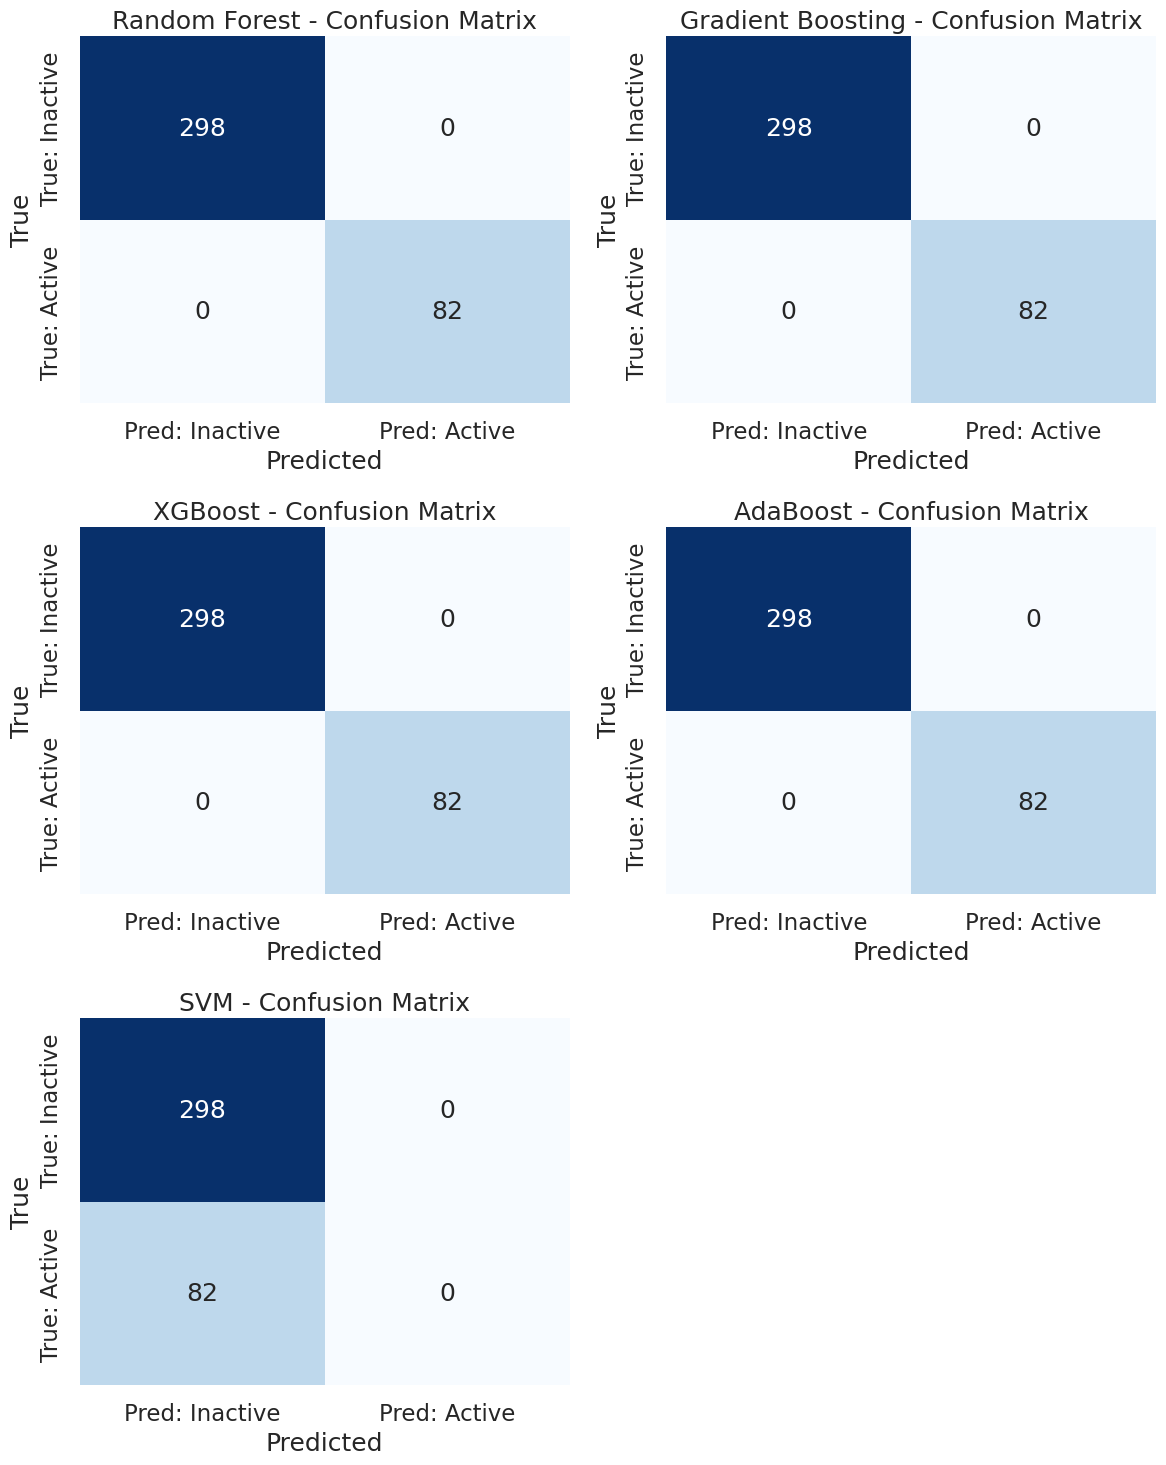


Model Comparison Summary:

F1 Scores:
Random Forest: 0.9431 (+/- 0.0224)
Gradient Boosting: 0.9145 (+/- 0.0125)
XGBoost: 0.9253 (+/- 0.0328)
AdaBoost: 0.8964 (+/- 0.0298)
SVM: 0.0000 (+/- 0.0000)

ROC AUC Scores:
Random Forest: 1.0000
Gradient Boosting: 1.0000
XGBoost: 1.0000
AdaBoost: 1.0000
SVM: 0.9566

PR AUC Scores:
Random Forest: 1.0000
Gradient Boosting: 1.0000
XGBoost: 1.0000
AdaBoost: 1.0000
SVM: 0.9073

Sensitivity (Recall) Scores:
Random Forest: 1.0000
Gradient Boosting: 1.0000
XGBoost: 1.0000
AdaBoost: 1.0000
SVM: 0.0000

Specificity Scores:
Random Forest: 1.0000
Gradient Boosting: 1.0000
XGBoost: 1.0000
AdaBoost: 1.0000
SVM: 1.0000

MCC Scores:
Random Forest: 1.0000
Gradient Boosting: 1.0000
XGBoost: 1.0000
AdaBoost: 1.0000
SVM: 0.0000


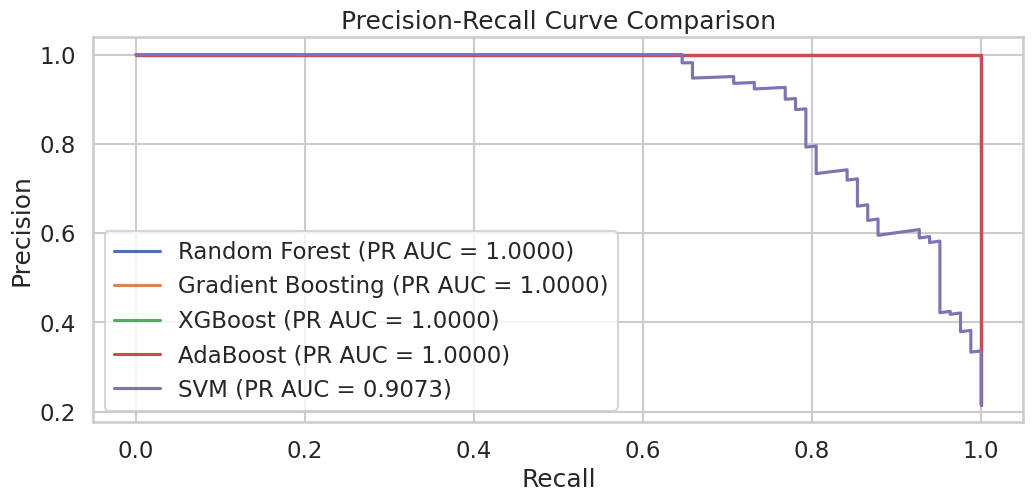

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (confusion_matrix, matthews_corrcoef, roc_auc_score,
                             average_precision_score, precision_recall_curve,
                             recall_score, classification_report)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Define models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),  # Support Vector Machine
}

# Prepare lists to store results
f1_scores = []
roc_aucs = []
pr_aucs = []
sensitivities = []
specificities = []
mcc_scores = []

X_train = pd.read_csv('/content/drive/MyDrive/PS/PS imbalance/X_train_features.csv')
y_train = pd.read_csv('/content/drive/MyDrive/PS/PS imbalance/y_train.csv').squeeze()

# --- FIX: Drop the 'Sequence' column from X_train before using it in model training/evaluation ---
if 'Sequence' in X_train.columns:
    X_train = X_train.drop(columns=['Sequence'])
# --------------------------------------------------------------------------------------------------

# Number of rows and columns for plotting
n_rows = (len(models) + 1) // 2  # To fit models in a 2-column layout
n_cols = 2

# Create a plot for confusion matrices
plt.figure(figsize=(12, n_rows * 5))  # Adjust height based on number of rows

# Train, evaluate, and collect metrics for each model
for i, (name, model) in enumerate(models.items(), 1):
    print(f"Evaluating {name}...")

    # Cross-validation F1 score
    # The error occurred here because X_train still contained the 'Sequence' column (string type)
    f1_cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    mean_f1 = np.mean(f1_cv_scores)
    std_f1 = np.std(f1_cv_scores)

    # Train the model on the entire training set for later evaluation
    model.fit(X_train, y_train)

    # ROC AUC Score
    y_prob = model.predict_proba(X_train)[:, 1]  # Probability for positive class
    roc_auc = roc_auc_score(y_train, y_prob)

    # PR AUC Score
    pr_auc = average_precision_score(y_train, y_prob)

    # Store results for comparison
    f1_scores.append((name, mean_f1, std_f1))
    roc_aucs.append((name, roc_auc))
    pr_aucs.append((name, pr_auc))

    # Confusion Matrix
    y_pred = model.predict(X_train)
    cm = confusion_matrix(y_train, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Calculate Sensitivity, Specificity, and MCC
    sensitivity = recall_score(y_train, y_pred)  # True Positive Rate
    specificity = tn / (tn + fp)  # True Negative Rate
    mcc = matthews_corrcoef(y_train, y_pred)

    # Store additional metrics
    sensitivities.append((name, sensitivity))
    specificities.append((name, specificity))
    mcc_scores.append((name, mcc))

    # Display metrics
    print(f"{name} - Mean F1 Score: {mean_f1:.4f} (+/- {std_f1:.4f})")
    print(f"{name} - ROC AUC: {roc_auc:.4f}")
    print(f"{name} - PR AUC: {pr_auc:.4f}")
    print(f"{name} - Sensitivity: {sensitivity:.4f}")
    print(f"{name} - Specificity: {specificity:.4f}")
    print(f"{name} - MCC: {mcc:.4f}")

    # Plot confusion matrix
    plt.subplot(n_rows, n_cols, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred: Inactive', 'Pred: Active'],
                yticklabels=['True: Inactive', 'True: Active'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()

# Summary of model comparison
print("\nModel Comparison Summary:")

# F1 Scores
print("\nF1 Scores:")
for model_name, f1, std in f1_scores:
    print(f"{model_name}: {f1:.4f} (+/- {std:.4f})")

# ROC AUC Scores
print("\nROC AUC Scores:")
for model_name, auc in roc_aucs:
    print(f"{model_name}: {auc:.4f}")

# PR AUC Scores
print("\nPR AUC Scores:")
for model_name, auc in pr_aucs:
    print(f"{model_name}: {auc:.4f}")

# Sensitivity
print("\nSensitivity (Recall) Scores:")
for model_name, sensitivity in sensitivities:
    print(f"{model_name}: {sensitivity:.4f}")

# Specificity
print("\nSpecificity Scores:")
for model_name, specificity in specificities:
    print(f"{model_name}: {specificity:.4f}")

# MCC Scores
print("\nMCC Scores:")
for model_name, mcc in mcc_scores:
    print(f"{model_name}: {mcc:.4f}")

# Optional: If you want to visualize PR curves for all models

plt.figure(figsize=(12, 5))
for i, (name, model) in enumerate(models.items(), 1):
    # Calculate Precision-Recall curve
    # Ensure X_train used here also has 'Sequence' dropped
    precision, recall, _ = precision_recall_curve(y_train, model.predict_proba(X_train)[:, 1])
    plt.plot(recall, precision, label=f'{name} (PR AUC = {pr_aucs[i-1][1]:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='lower left')
plt.show()

Evaluating and Saving Random Forest...
✅ Saved model: /content/drive/MyDrive/PS/PS imbalance/pretrain_random_forest_model.pkl
Random Forest - Mean CV F1 Score: 0.9431 (+/- 0.0224)
Random Forest - Train ROC AUC: 1.0000
Random Forest - Train PR AUC: 1.0000
Random Forest - Train Sensitivity: 1.0000
Random Forest - Train Specificity: 1.0000
Random Forest - Train MCC: 1.0000
Evaluating and Saving Gradient Boosting...
✅ Saved model: /content/drive/MyDrive/PS/PS imbalance/pretrain_gradient_boosting_model.pkl
Gradient Boosting - Mean CV F1 Score: 0.9145 (+/- 0.0125)
Gradient Boosting - Train ROC AUC: 1.0000
Gradient Boosting - Train PR AUC: 1.0000
Gradient Boosting - Train Sensitivity: 1.0000
Gradient Boosting - Train Specificity: 1.0000
Gradient Boosting - Train MCC: 1.0000
Evaluating and Saving XGBoost...
✅ Saved model: /content/drive/MyDrive/PS/PS imbalance/pretrain_xgboost_model.pkl
XGBoost - Mean CV F1 Score: 0.9253 (+/- 0.0328)
XGBoost - Train ROC AUC: 1.0000
XGBoost - Train PR AUC: 1.00

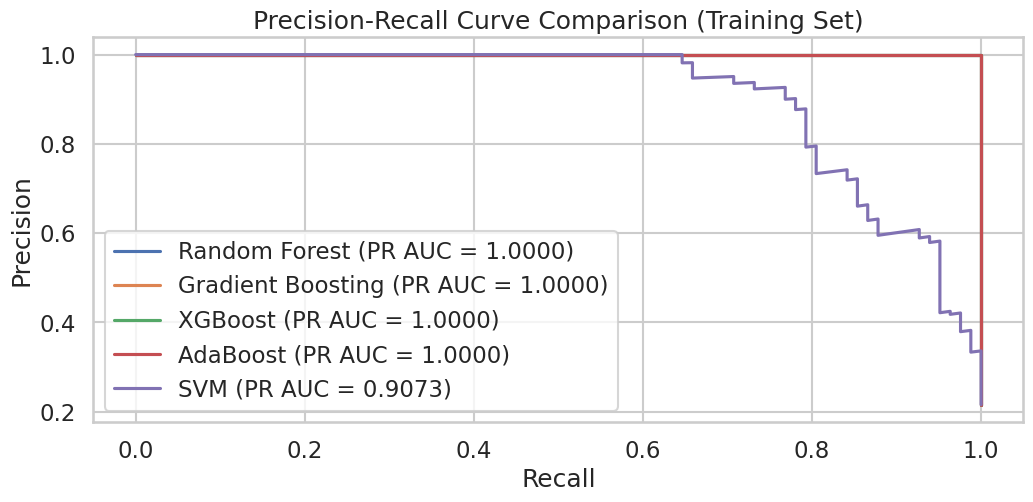

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (confusion_matrix, matthews_corrcoef, roc_auc_score,
                             average_precision_score, precision_recall_curve,
                             recall_score, classification_report, f1_score) # Added f1_score here
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import joblib # Added import
import os # Added import

# Define models as a dictionary (ensure this is a dictionary, not a list)
# This definition should be present in the cell where the loop runs
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),  # Support Vector Machine
}

# Prepare lists to store results (these were defined in previous cells,
# but re-defining them here ensures they are clear for the loop's results)
f1_scores = []
roc_aucs = []
pr_aucs = []
sensitivities = []
specificities = []
mcc_scores = []

# Load data (Assuming these files exist and are correct)
X_train = pd.read_csv('/content/drive/MyDrive/PS/PS imbalance/X_train_features.csv')
y_train = pd.read_csv('/content/drive/MyDrive/PS/PS imbalance/y_train.csv').squeeze()

# Drop the 'Sequence' column from X_train if it exists, as models cannot process strings
if 'Sequence' in X_train.columns:
    X_train = X_train.drop(columns=['Sequence'])

# Number of rows and columns for plotting (ensure n_rows is calculated based on the dictionary)
n_rows = (len(models) + 1) // 2
n_cols = 2

# Create a plot for confusion matrices (if needed for this loop)
# plt.figure(figsize=(12, n_rows * 5)) # Only uncomment if you plan to plot CMs *inside* this loop

# Define save directory on Google Drive (ensure this is defined)
model_dir = '/content/drive/MyDrive/PS/PS imbalance'
os.makedirs(model_dir, exist_ok=True)

# Train, evaluate, and collect metrics for each model
# Added a list to store model evaluation results to display after the loop
evaluation_results = []

for i, (name, model) in enumerate(models.items(), 1):
    print(f"Evaluating and Saving {name}...")

    # Cross-validation F1 score
    f1_cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    mean_f1 = np.mean(f1_cv_scores)
    std_f1 = np.std(f1_cv_scores)

    # Train the model on the entire training set
    model.fit(X_train, y_train)

    # Save model right here
    model_filename = os.path.join(model_dir, f"pretrain_{name.replace(' ', '_').lower()}_model.pkl")
    joblib.dump(model, model_filename)
    print(f"✅ Saved model: {model_filename}")

    # Predict and calculate metrics on the *training* set
    y_pred_train = model.predict(X_train)
    y_prob_train = model.predict_proba(X_train)[:, 1] # Probability for positive class

    roc_auc_train = roc_auc_score(y_train, y_prob_train)
    pr_auc_train = average_precision_score(y_train, y_prob_train)
    f1_train = f1_score(y_train, y_pred_train)
    cm_train = confusion_matrix(y_train, y_pred_train)
    tn_train, fp_train, fn_train, tp_train = cm_train.ravel()

    sensitivity_train = recall_score(y_train, y_pred_train)  # True Positive Rate
    specificity_train = tn_train / (tn_train + fp_train)  # True Negative Rate
    mcc_train = matthews_corrcoef(y_train, y_pred_train)


    # Store results for comparison
    # Appending to lists defined earlier
    f1_scores.append((name, mean_f1, std_f1)) # Using CV F1
    roc_aucs.append((name, roc_auc_train))
    pr_aucs.append((name, pr_auc_train))
    sensitivities.append((name, sensitivity_train))
    specificities.append((name, specificity_train))
    mcc_scores.append((name, mcc_train))

    # Display metrics (optional to print inside the loop or summarize later)
    print(f"{name} - Mean CV F1 Score: {mean_f1:.4f} (+/- {std_f1:.4f})")
    print(f"{name} - Train ROC AUC: {roc_auc_train:.4f}")
    print(f"{name} - Train PR AUC: {pr_auc_train:.4f}")
    print(f"{name} - Train Sensitivity: {sensitivity_train:.4f}")
    print(f"{name} - Train Specificity: {specificity_train:.4f}")
    print(f"{name} - Train MCC: {mcc_train:.4f}")


# Summary of model comparison (after the loop)
print("\nModel Comparison Summary (Training Set Metrics):")

# F1 Scores (CV Mean)
print("\nF1 Scores (Mean CV):")
for model_name, f1, std in f1_scores:
    print(f"{model_name}: {f1:.4f} (+/- {std:.4f})")

# ROC AUC Scores (Train Set)
print("\nROC AUC Scores (Train Set):")
for model_name, auc in roc_aucs:
    print(f"{model_name}: {auc:.4f}")

# PR AUC Scores (Train Set)
print("\nPR AUC Scores (Train Set):")
for model_name, auc in pr_aucs:
    print(f"{model_name}: {auc:.4f}")

# Sensitivity (Train Set)
print("\nSensitivity (Recall) Scores (Train Set):")
for model_name, sensitivity in sensitivities:
    print(f"{model_name}: {sensitivity:.4f}")

# Specificity (Train Set)
print("\nSpecificity Scores (Train Set):")
for model_name, specificity in specificities:
    print(f"{model_name}: {specificity:.4f}")

# MCC Scores (Train Set)
print("\nMCC Scores (Train Set):")
for model_name, mcc in mcc_scores:
    print(f"{model_name}: {mcc:.4f}")

# If you want to visualize PR curves for all models (using training data)
plt.figure(figsize=(12, 5))
for i, (name, model) in enumerate(models.items(), 1):
    # Calculate Precision-Recall curve
    # Ensure X_train used here also has 'Sequence' dropped
    # Predict probabilities for the positive class (for PR curve)
    try:
        y_prob_train = model.predict_proba(X_train)[:, 1]
    except AttributeError:
         # Fallback if predict_proba is not available (e.g., some SVM configs)
         # Use decision_function or predict as a fallback, though PR curve from predictions is less informative
         if hasattr(model, 'decision_function'):
             y_prob_train = model.decision_function(X_train)
         else:
            y_prob_train = model.predict(X_train)
            print(f"Warning: Model {name} does not have predict_proba or decision_function for PR curve.")


    precision, recall, _ = precision_recall_curve(y_train, y_prob_train)
    # Find the corresponding PR AUC score from the list
    current_pr_auc = [auc for n, auc in pr_aucs if n == name][0]
    plt.plot(recall, precision, label=f'{name} (PR AUC = {current_pr_auc:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison (Training Set)')
plt.legend(loc='lower left')
plt.show()

Tuning Random Forest...
Random Forest model saved as '/content/drive/MyDrive/PS/PS imbalance/random_forest_best_model.pkl'
Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 10}
Best ROC AUC Score for Random Forest: 0.9959293107441255
Tuning Gradient Boosting...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Gradient Boosting model saved as '/content/drive/MyDrive/PS/PS imbalance/gradient_boosting_best_model.pkl'
Best Parameters for Gradient Boosting: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
Best ROC AUC Score for Gradient Boosting: 0.9871063367359664
Tuning XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


XGBoost model saved as '/content/drive/MyDrive/PS/PS imbalance/xgboost_best_model.pkl'
Best Parameters for XGBoost: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
Best ROC AUC Score for XGBoost: 0.9898104501808205
Tuning AdaBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AdaBoost model saved as '/content/drive/MyDrive/PS/PS imbalance/adaboost_best_model.pkl'
Best Parameters for AdaBoost: {'n_estimators': 100, 'learning_rate': 0.1}
Best ROC AUC Score for AdaBoost: 0.9781703276147721
Tuning SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


SVM model saved as '/content/drive/MyDrive/PS/PS imbalance/svm_best_model.pkl'
Best Parameters for SVM: {'kernel': 'linear', 'class_weight': 'balanced', 'C': 1}
Best ROC AUC Score for SVM: 0.9896194751750308
Evaluating Random Forest on Test Set...
Evaluating Gradient Boosting on Test Set...
Evaluating XGBoost on Test Set...
Evaluating AdaBoost on Test Set...
Evaluating SVM on Test Set...


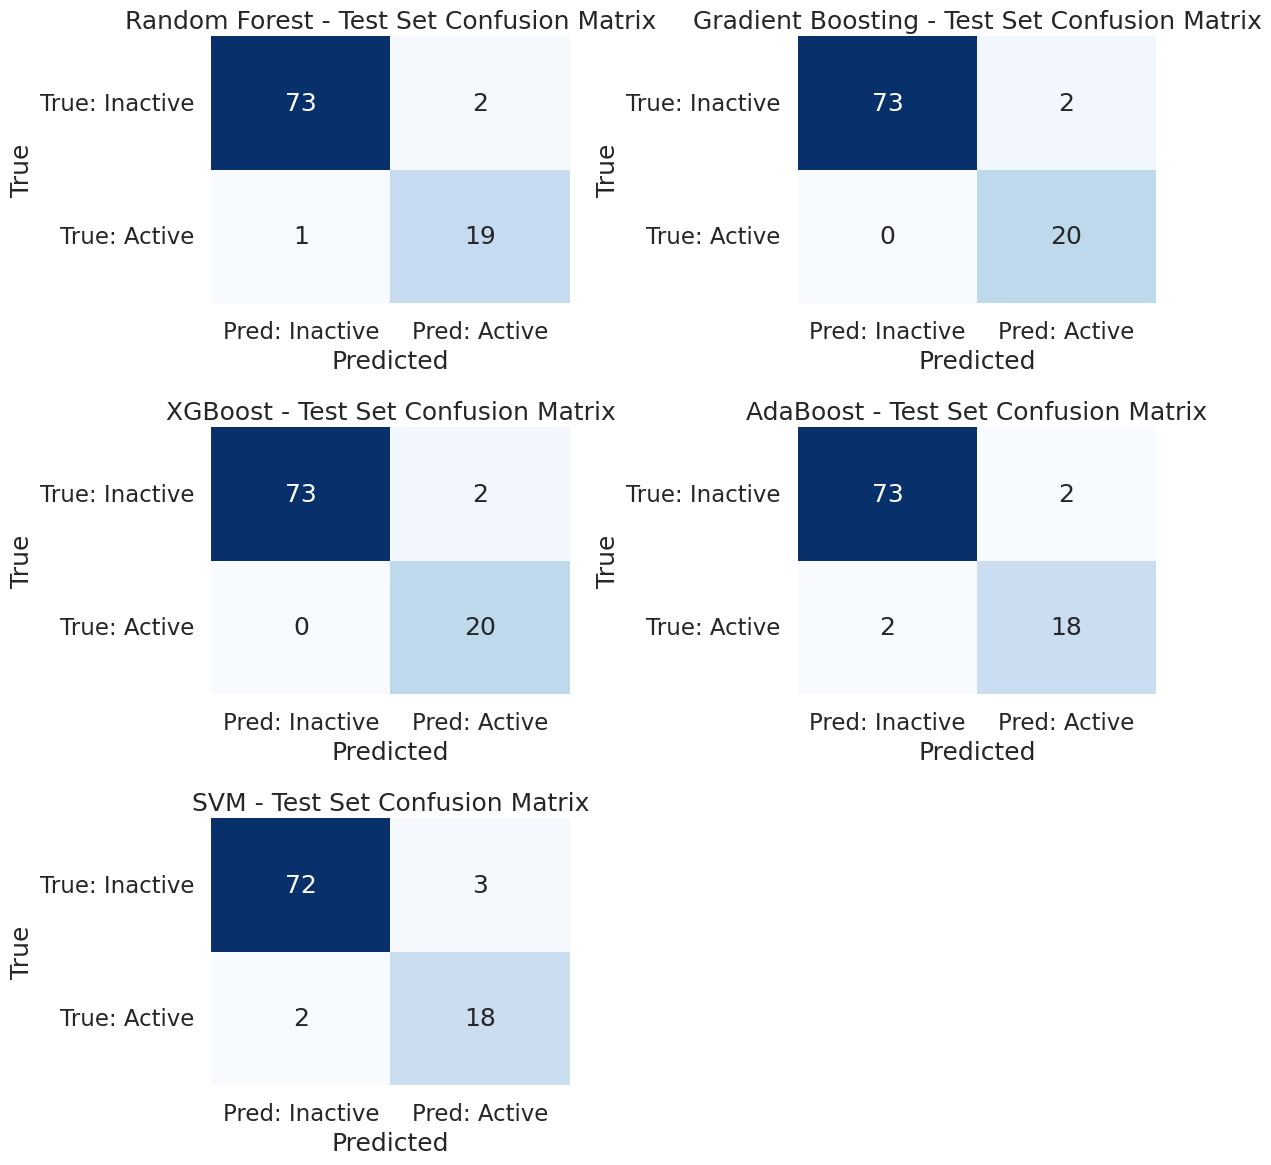


Model Comparison on Test Set:

F1 Scores (Test Set):
Random Forest: 0.9268
Gradient Boosting: 0.9524
XGBoost: 0.9524
AdaBoost: 0.9000
SVM: 0.8780

ROC AUC Scores (Test Set):
Random Forest: 0.9967
Gradient Boosting: 1.0000
XGBoost: 0.9967
AdaBoost: 0.9853
SVM: 0.9787

PR AUC Scores (Test Set):
Random Forest: 0.9883
Gradient Boosting: 1.0000
XGBoost: 0.9875
AdaBoost: 0.9299
SVM: 0.8978

Sensitivity (Recall) Scores (Test Set):
Random Forest: 0.9500
Gradient Boosting: 1.0000
XGBoost: 1.0000
AdaBoost: 0.9000
SVM: 0.9000

Specificity Scores (Test Set):
Random Forest: 0.9733
Gradient Boosting: 0.9733
XGBoost: 0.9733
AdaBoost: 0.9733
SVM: 0.9600

MCC Scores (Test Set):
Random Forest: 0.9071
Gradient Boosting: 0.9407
XGBoost: 0.9407
AdaBoost: 0.8733
SVM: 0.8449


In [23]:
import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np
import pandas as pd # Import pandas

# Define reduced hyperparameter grids for each model (randomized search)
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3, 5]
    },
    'XGBoost': {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3, 5]
    },
    'Decision Tree': {
        'max_depth': [10, 20],
        'min_samples_split': [2, 5]
    },
    'AdaBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.1]
    },
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,)],
        'max_iter': [200, 300],
        'learning_rate_init': [0.01]
    },
    'SVM': {
        'C': [1, 10],
        'kernel': ['linear'],
        'class_weight': ['balanced']
    }
}

# Models to tune
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# --- FIX: Load X_train and y_train here ---
# Correcting the path to where the feature-engineered files were saved
X_train_path = '/content/drive/MyDrive/PS/PS imbalance/X_train_features.csv'
y_train_path = '/content/drive/MyDrive/PS/PS imbalance/y_train.csv'
X_test_path = '/content/drive/MyDrive/PS/PS imbalance/X_test_features.csv'
y_test_path = '/content/drive/MyDrive/PS/PS imbalance/y_test.csv'

X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path).squeeze() # Use squeeze() to get a Series if it's a single column DataFrame
X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path).squeeze()

# --- FIX: Drop the 'Sequence' column from X_train and X_test if it exists ---
if 'Sequence' in X_train.columns:
    X_train = X_train.drop(columns=['Sequence'])
if 'Sequence' in X_test.columns:
    X_test = X_test.drop(columns=['Sequence'])
# ---------------------------------------------------------------------------


# Step 1: Perform RandomizedSearchCV for each model to save time
best_models = {}
for model_name, model in models.items():
    print(f"Tuning {model_name}...")

    # Perform randomized search with reduced hyperparameters
    random_search = RandomizedSearchCV(model, param_distributions=param_grids[model_name], n_iter=5, cv=3, scoring='roc_auc', n_jobs=-1)
    random_search.fit(X_train, y_train)

    # Save the best model
    best_models[model_name] = random_search.best_estimator_

    # Save the model
    model_filename = f'/content/drive/MyDrive/PS/PS imbalance/{model_name.replace(" ", "_").lower()}_best_model.pkl'
    joblib.dump(best_models[model_name], model_filename)
    print(f"{model_name} model saved as '{model_filename}'")

    # Print the best parameters
    print(f"Best Parameters for {model_name}: {random_search.best_params_}")
    print(f"Best ROC AUC Score for {model_name}: {random_search.best_score_}")

# Step 2: Evaluate each best model on the test set
test_roc_aucs = []
test_pr_aucs = []
test_f1_scores = []
test_sensitivities = []
test_specificities = []
test_mcc_scores = []

plt.figure(figsize=(12, 12))  # Adjust size for the number of models

for i, (model_name, model) in enumerate(best_models.items(), 1):
    print(f"Evaluating {model_name} on Test Set...")

    # Predict probabilities for the positive class (for AUC/PR AUC)
    # Need to handle models that don't have predict_proba (like some SVMs)
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        # Fallback for models without predict_proba (e.g., linear SVM decision_function)
        # Note: This might not be suitable for all models, especially non-linear SVMs without probability=True
        if hasattr(model, 'decision_function'):
             y_prob = model.decision_function(X_test)
             # For binary classification, decision_function often outputs score where positive means class 1
             # For ROC AUC and PR AUC with decision_function, the raw scores can be used
        else:
            # As a last resort, use the prediction itself, though this loses probability information
            y_prob = model.predict(X_test)
            print(f"Warning: Model {model_name} does not have predict_proba or decision_function. Using raw predictions for AUC/PR AUC (might be inaccurate).")


    # Calculate the metrics
    y_pred = model.predict(X_test) # Get predictions for confusion matrix and F1
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred) # Use y_pred here
    cm = confusion_matrix(y_test, y_pred) # Use y_pred here
    tn, fp, fn, tp = cm.ravel()

    # Calculate Sensitivity, Specificity, and MCC
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0 # True Positive Rate (Recall)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 # True Negative Rate
    mcc = matthews_corrcoef(y_test, y_pred) # Use y_pred here

    # Store the results
    test_roc_aucs.append((model_name, roc_auc))
    test_pr_aucs.append((model_name, pr_auc))
    test_f1_scores.append((model_name, f1))
    test_sensitivities.append((model_name, sensitivity))
    test_specificities.append((model_name, specificity))
    test_mcc_scores.append((model_name, mcc))

    # Plot confusion matrix
    plt.subplot(len(best_models) // 2 + 1, 2, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred: Inactive', 'Pred: Active'],
                yticklabels=['True: Inactive', 'True: Active'])
    plt.title(f"{model_name} - Test Set Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()

# Step 3: Summary of test set performance
print("\nModel Comparison on Test Set:")

# F1 Scores
print("\nF1 Scores (Test Set):")
for model_name, f1 in test_f1_scores:
    print(f"{model_name}: {f1:.4f}")

# ROC AUC Scores
print("\nROC AUC Scores (Test Set):")
for model_name, auc in test_roc_aucs:
    print(f"{model_name}: {auc:.4f}")

# PR AUC Scores
print("\nPR AUC Scores (Test Set):")
for model_name, auc in test_pr_aucs:
    print(f"{model_name}: {auc:.4f}")

# Sensitivity
print("\nSensitivity (Recall) Scores (Test Set):")
for model_name, sensitivity in test_sensitivities:
    print(f"{model_name}: {sensitivity:.4f}")

# Specificity
print("\nSpecificity Scores (Test Set):")
for model_name, specificity in test_specificities:
    print(f"{model_name}: {specificity:.4f}")

# MCC Scores
print("\nMCC Scores (Test Set):")
for model_name, mcc in test_mcc_scores:
    print(f"{model_name}: {mcc:.4f}")

Loaded model: Random Forest
Loaded model: Gradient Boosting
Loaded model: Xgboost
Loaded model: Adaboost
Loaded model: Svm

Evaluating model: Random Forest
Accuracy   : 0.9684
F1 Score   : 0.9268
Sensitivity: 0.9500
Specificity: 0.9733
MCC        : 0.9071
ROC AUC    : 0.9967
PR AUC     : 0.9883

Evaluating model: Gradient Boosting
Accuracy   : 0.9789
F1 Score   : 0.9524
Sensitivity: 1.0000
Specificity: 0.9733
MCC        : 0.9407
ROC AUC    : 1.0000
PR AUC     : 1.0000

Evaluating model: Xgboost
Accuracy   : 0.9789
F1 Score   : 0.9524
Sensitivity: 1.0000
Specificity: 0.9733
MCC        : 0.9407
ROC AUC    : 0.9967
PR AUC     : 0.9875

Evaluating model: Adaboost
Accuracy   : 0.9579
F1 Score   : 0.9000
Sensitivity: 0.9000
Specificity: 0.9733
MCC        : 0.8733
ROC AUC    : 0.9853
PR AUC     : 0.9299

Evaluating model: Svm
Accuracy   : 0.9474
F1 Score   : 0.8780
Sensitivity: 0.9000
Specificity: 0.9600
MCC        : 0.8449
ROC AUC    : 0.9787
PR AUC     : 0.8978


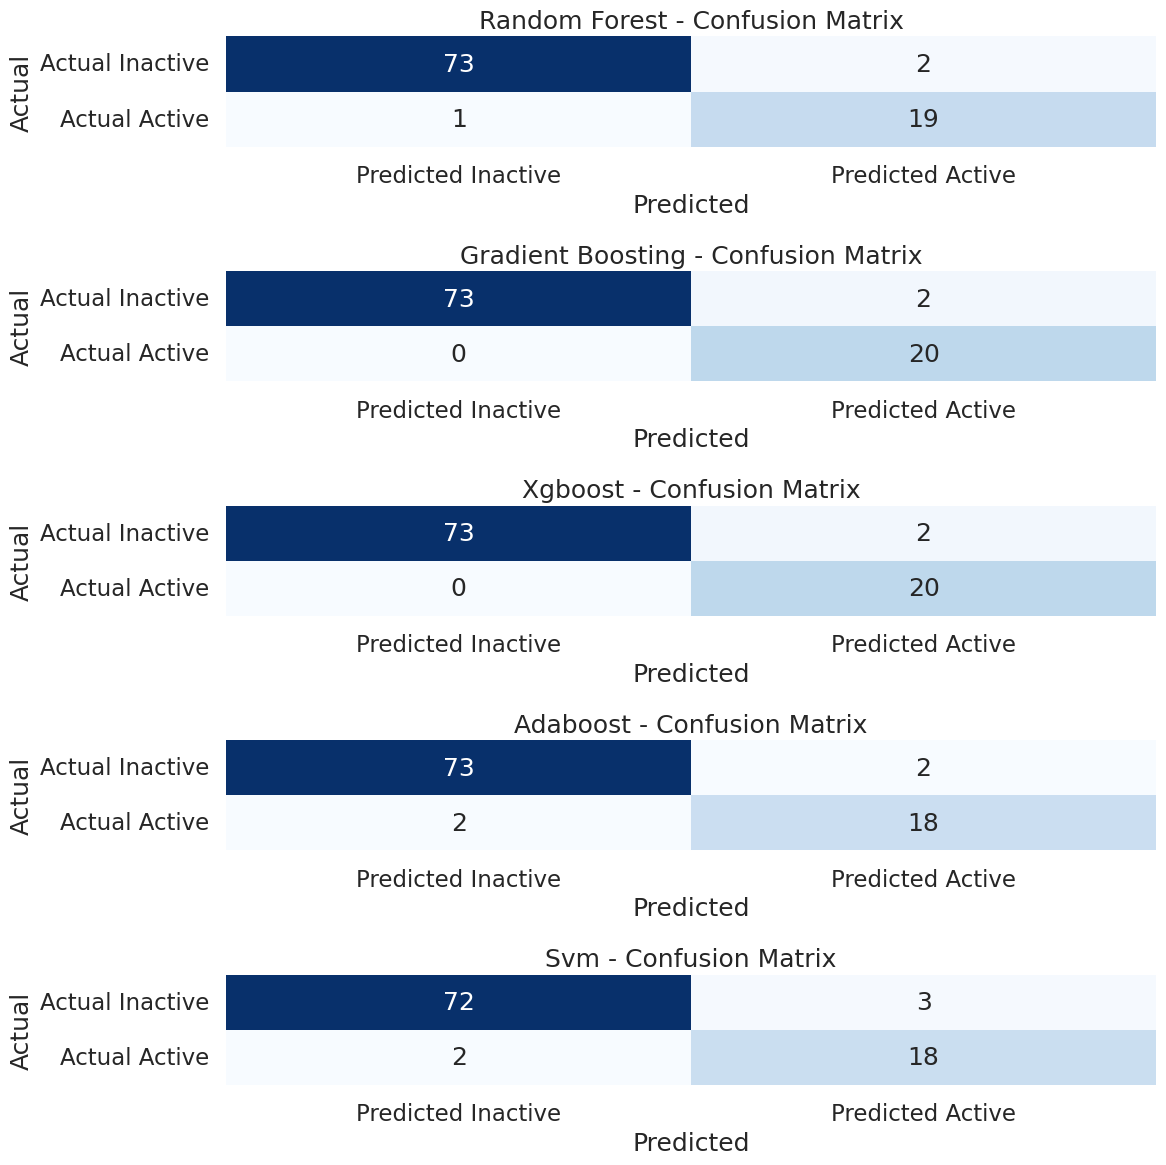

In [24]:
import joblib
import os
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    confusion_matrix, matthews_corrcoef, recall_score
)
import seaborn as sns
import matplotlib.pyplot as plt

# Paths and filenames where models are saved
model_dir = '/content/drive/MyDrive/PS/PS imbalance/'
model_filenames = [
    'random_forest_best_model.pkl',
    'gradient_boosting_best_model.pkl',
    'xgboost_best_model.pkl',
    'adaboost_best_model.pkl',
    'svm_best_model.pkl'
]

# Load test data
X_test = pd.read_csv('/content/drive/MyDrive/PS/PS imbalance/X_test_features.csv')
y_test = pd.read_csv('/content/drive/MyDrive/PS/PS imbalance/y_test.csv').squeeze()

# Drop 'Sequence' column if present
if 'Sequence' in X_test.columns:
    X_test = X_test.drop(columns=['Sequence'])

# Dictionary to store loaded models
loaded_models = {}

# Load models
for filename in model_filenames:
    path = os.path.join(model_dir, filename)
    if os.path.exists(path):
        model_name = filename.replace('_best_model.pkl', '').replace('_', ' ').title()
        loaded_models[model_name] = joblib.load(path)
        print(f"Loaded model: {model_name}")
    else:
        print(f"Model file not found: {filename}")

# Evaluate loaded models on test set
results = []

plt.figure(figsize=(12, 12))
for i, (name, model) in enumerate(loaded_models.items(), 1):
    print(f"\nEvaluating model: {name}")

    # Predict probabilities or fallback to decision_function/predictions
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        if hasattr(model, 'decision_function'):
            y_prob = model.decision_function(X_test)
        else:
            y_prob = model.predict(X_test)
            print(f"Warning: {name} does not support predict_proba or decision_function; metrics may be less reliable.")

    y_pred = model.predict(X_test)

    # Metrics calculation
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    mcc = matthews_corrcoef(y_test, y_pred)
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    print(f"Accuracy   : {accuracy:.4f}")
    print(f"F1 Score   : {f1:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"MCC        : {mcc:.4f}")
    print(f"ROC AUC    : {roc_auc:.4f}")
    print(f"PR AUC     : {pr_auc:.4f}")

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'MCC': mcc,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc,
        'Confusion Matrix': cm
    })

    # Plot confusion matrix
    plt.subplot(len(loaded_models), 1, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Inactive', 'Predicted Active'],
                yticklabels=['Actual Inactive', 'Actual Active'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()


Loaded model: Random Forest
Loaded model: Gradient Boosting
Loaded model: Xgboost
Loaded model: Adaboost
Loaded model: Svm

Evaluating model: Random Forest
Accuracy   : 0.9684
F1 Score   : 0.9268
Precision  : 0.9048
Recall     : 0.9500
Sensitivity: 0.9500
Specificity: 0.9733
MCC        : 0.9071
ROC AUC    : 0.9967
PR AUC     : 0.9883

Evaluating model: Gradient Boosting
Accuracy   : 0.9789
F1 Score   : 0.9524
Precision  : 0.9091
Recall     : 1.0000
Sensitivity: 1.0000
Specificity: 0.9733
MCC        : 0.9407
ROC AUC    : 1.0000
PR AUC     : 1.0000

Evaluating model: Xgboost
Accuracy   : 0.9789
F1 Score   : 0.9524
Precision  : 0.9091
Recall     : 1.0000
Sensitivity: 1.0000
Specificity: 0.9733
MCC        : 0.9407
ROC AUC    : 0.9967
PR AUC     : 0.9875

Evaluating model: Adaboost
Accuracy   : 0.9579
F1 Score   : 0.9000
Precision  : 0.9000
Recall     : 0.9000
Sensitivity: 0.9000
Specificity: 0.9733
MCC        : 0.8733
ROC AUC    : 0.9853
PR AUC     : 0.9299

Evaluating model: Svm
Accuracy 

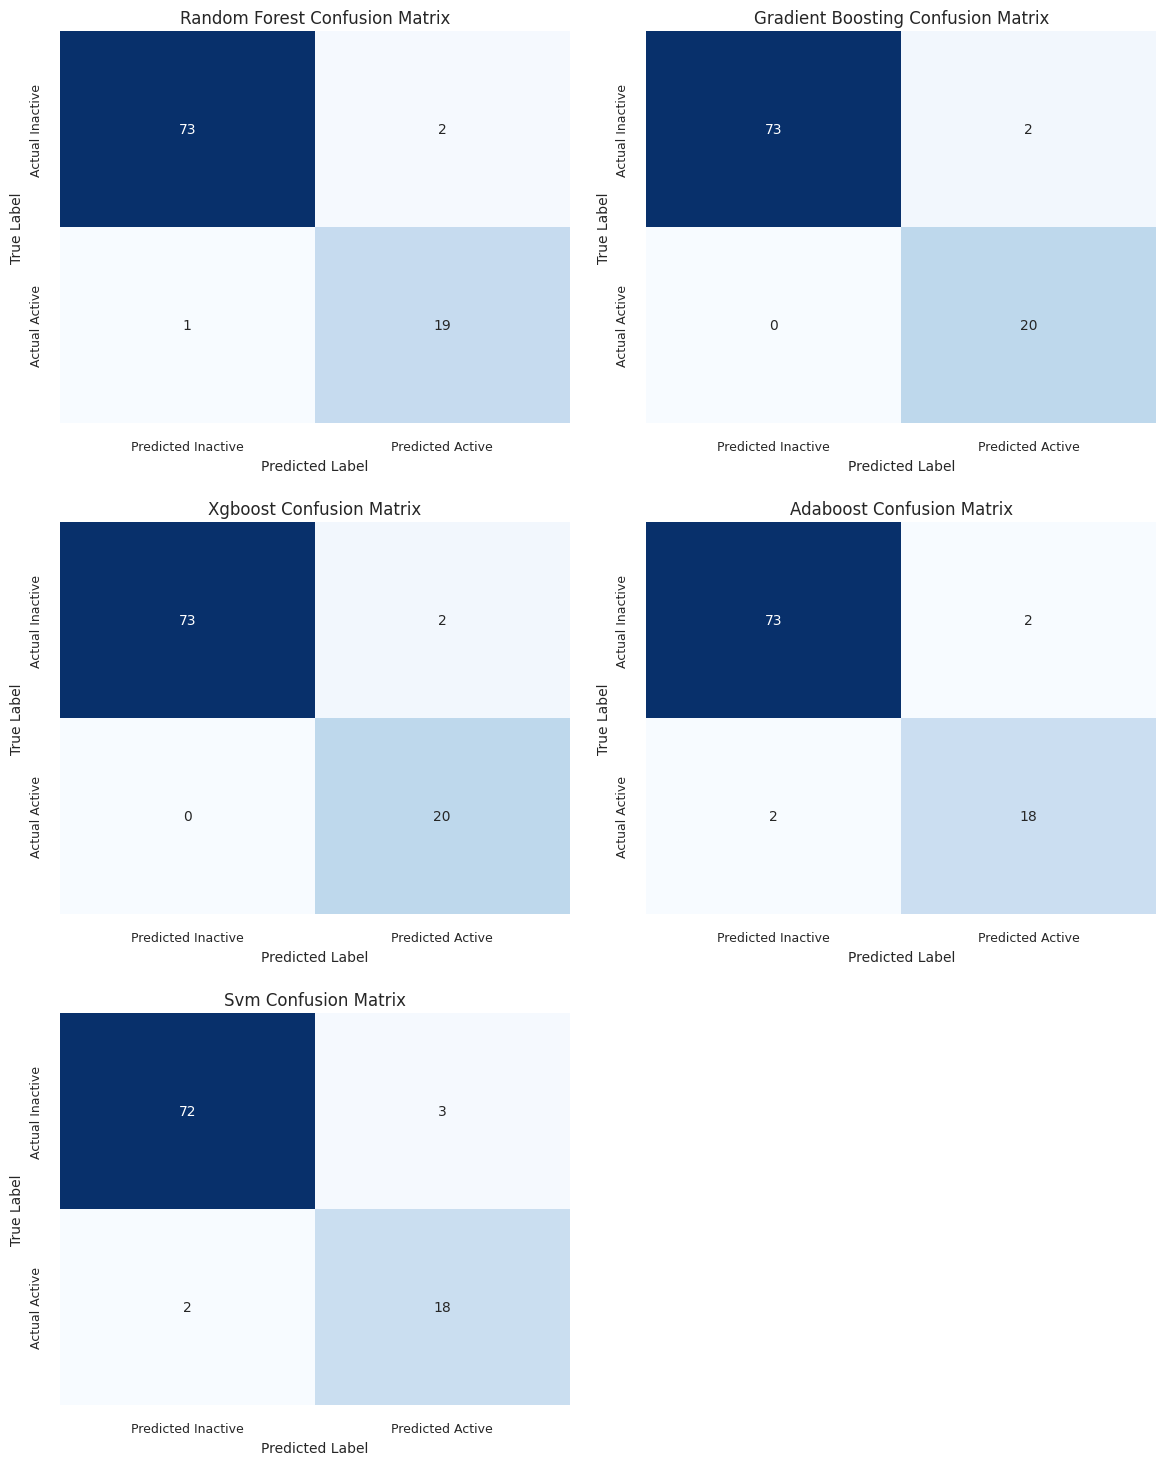

In [28]:
import joblib
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    confusion_matrix, matthews_corrcoef, recall_score, accuracy_score,
    precision_score
)
import numpy as np

# Paths to saved models
model_dir = '/content/drive/MyDrive/PS/PS imbalance/'
model_filenames = [
    'random_forest_best_model.pkl',
    'gradient_boosting_best_model.pkl',
    'xgboost_best_model.pkl',
    'adaboost_best_model.pkl',
    'svm_best_model.pkl'
]

# Load test data
X_test = pd.read_csv('/content/drive/MyDrive/PS/PS imbalance/X_test_features.csv')
y_test = pd.read_csv('/content/drive/MyDrive/PS/PS imbalance/y_test.csv').squeeze()

# Drop 'Sequence' column if present
if 'Sequence' in X_test.columns:
    X_test = X_test.drop(columns=['Sequence'])

# Load models
loaded_models = {}
for filename in model_filenames:
    path = os.path.join(model_dir, filename)
    if os.path.exists(path):
        model_name = filename.replace('_best_model.pkl', '').replace('_', ' ').title()
        loaded_models[model_name] = joblib.load(path)
        print(f"Loaded model: {model_name}")
    else:
        print(f"Model file not found: {filename}")

# Prepare plot for confusion matrices
num_models = len(loaded_models)
cols = 2
rows = (num_models + 1) // 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
if num_models == 1:
    axes = np.array([axes])  # Ensure axes is iterable

axes = axes.flatten()

# Evaluate and plot
for i, (name, model) in enumerate(loaded_models.items()):
    print(f"\nEvaluating model: {name}")

    # Predict probabilities or decision function
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        if hasattr(model, 'decision_function'):
            y_prob = model.decision_function(X_test)
        else:
            y_prob = model.predict(X_test)
            print(f"Warning: {name} does not support predict_proba or decision_function; metrics may be less reliable.")

    y_pred = model.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"Accuracy   : {accuracy:.4f}")
    print(f"F1 Score   : {f1:.4f}")
    print(f"Precision  : {precision:.4f}")
    print(f"Recall     : {recall:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"MCC        : {mcc:.4f}")
    print(f"ROC AUC    : {roc_auc:.4f}")
    print(f"PR AUC     : {pr_auc:.4f}")

    # Plot confusion matrix with smaller font sizes
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                annot_kws={"size": 10},
                xticklabels=['Predicted Inactive', 'Predicted Active'],
                yticklabels=['Actual Inactive', 'Actual Active'],
                ax=axes[i])
    axes[i].set_title(f"{name} Confusion Matrix", fontsize=12)
    axes[i].set_xlabel('Predicted Label', fontsize=10)
    axes[i].set_ylabel('True Label', fontsize=10)
    axes[i].tick_params(axis='both', which='major', labelsize=9)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


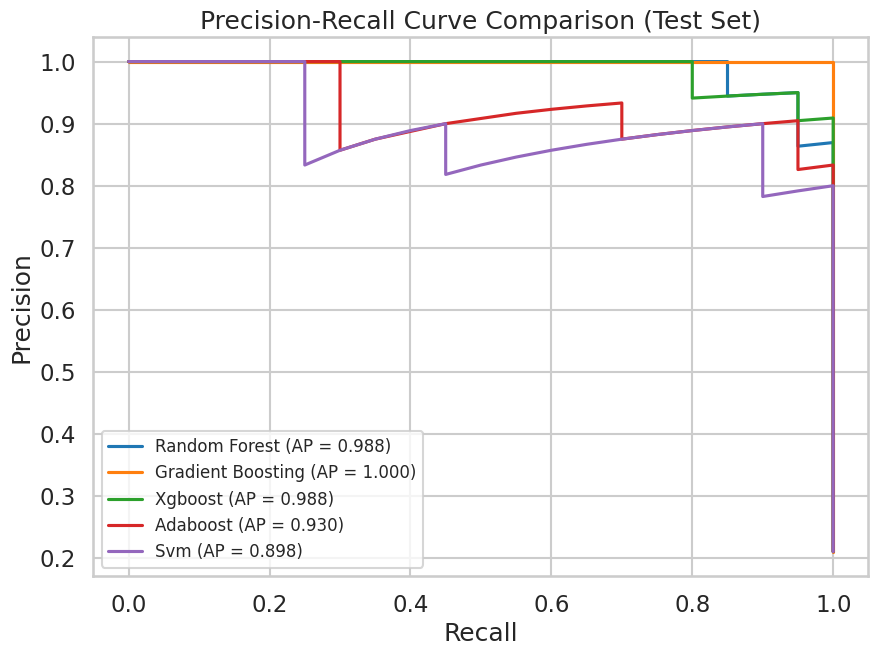

In [33]:
import joblib
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Paths and filenames
model_dir = '/content/drive/MyDrive/PS/PS imbalance/'
model_filenames = [
    'random_forest_best_model.pkl',
    'gradient_boosting_best_model.pkl',
    'xgboost_best_model.pkl',
    'adaboost_best_model.pkl',
    'svm_best_model.pkl'
]

# Load test data
X_test = pd.read_csv('/content/drive/MyDrive/PS/PS imbalance/X_test_features.csv')
y_test = pd.read_csv('/content/drive/MyDrive/PS/PS imbalance/y_test.csv').squeeze()

# Drop non-numeric 'Sequence' if present
if 'Sequence' in X_test.columns:
    X_test = X_test.drop(columns=['Sequence'])

# Load models
loaded_models = {}
for filename in model_filenames:
    path = os.path.join(model_dir, filename)
    if os.path.exists(path):
        model_name = filename.replace('_best_model.pkl', '').replace('_', ' ').title()
        loaded_models[model_name] = joblib.load(path)
    else:
        print(f"Model file not found: {filename}")

# Setup plot
plt.figure(figsize=(10, 7))
plt.title('Precision-Recall Curve Comparison (Test Set)')
plt.xlabel('Recall')
plt.ylabel('Precision')

colors = plt.get_cmap('tab10').colors

# Plot PR curve for each model
for i, (name, model) in enumerate(loaded_models.items()):
    try:
        y_scores = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        if hasattr(model, 'decision_function'):
            y_scores = model.decision_function(X_test)
        else:
            y_scores = model.predict(X_test)
            print(f"Warning: {name} does not support predict_proba or decision_function; PR curve may be inaccurate.")

    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    ap_score = average_precision_score(y_test, y_scores)

    plt.plot(recall, precision, label=f'{name} (AP = {ap_score:.3f})', color=colors[i % len(colors)])

plt.legend(loc='lower left', fontsize=12)
plt.grid(True)
plt.show()


In [35]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=459897453699f7735fd58a1dd473d883229ba108d15c99e65a5f457694528fef
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


LIME Explanation for test instance index 0:
4.00 < Charge <= 6.00: 0.1081
K > 19.81: 0.0939
9.61 < Isoelectric_Point <= 10.79: 0.0860
D <= 0.00: 0.0670
E <= 0.00: 0.0500
Q <= 0.00: 0.0214
N <= 0.00: 0.0208
4.00 < S <= 8.79: -0.0193
Y <= 0.00: 0.0184
0.40 < Flexibility <= 0.47: 0.0184


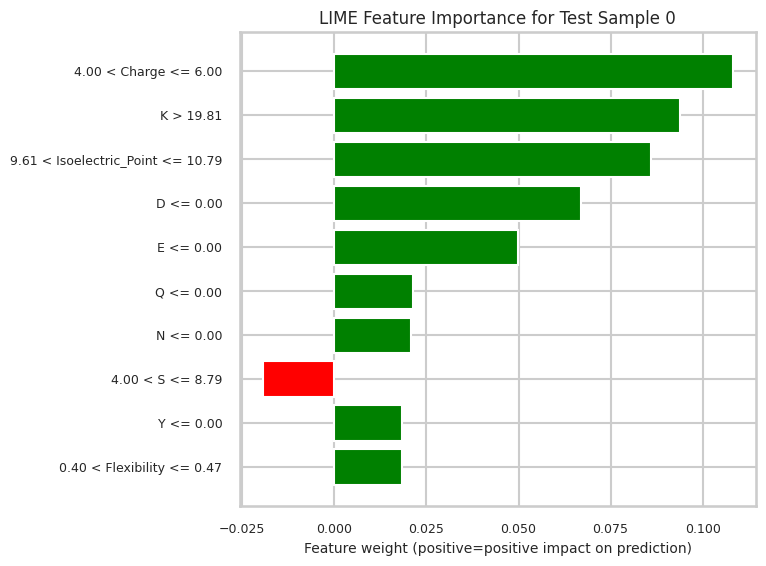

In [42]:
import joblib
import pandas as pd
import numpy as np
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Load the saved model
model_path = '/content/drive/MyDrive/EC/EC balance/saved_models/Random_Forest_model.pkl'
model = joblib.load(model_path)

# Load training data (for LIME explainer background)
X_train = pd.read_csv('/content/drive/MyDrive/EC/EC balance/X_train_balanced.csv')
if 'Sequence' in X_train.columns:
    X_train = X_train.drop(columns=['Sequence'])

# Load test data
X_test = pd.read_csv('/content/drive/MyDrive/EC/EC balance/X_test_features.csv')
if 'Sequence' in X_test.columns:
    X_test = X_test.drop(columns=['Sequence'])

feature_names = X_train.columns.tolist()
class_names = ['Inactive', 'Active']

# Initialize LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Select an instance from the test set to explain
idx = 0
instance = X_test.iloc[idx].values

# Explain the instance's prediction
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=model.predict_proba,
    num_features=10
)

# Print explanation
print(f"LIME Explanation for test instance index {idx}:")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")

# Plot LIME explanation with reduced font size
features, weights = zip(*exp.as_list())
plt.figure(figsize=(8, 6))
colors = ['green' if w > 0 else 'red' for w in weights]
plt.barh(features, weights, color=colors)
plt.title(f'LIME Feature Importance for Test Sample {idx}', fontsize=12)
plt.xlabel('Feature weight (positive=positive impact on prediction)', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
